Updated based on Using SHAP explainability analysis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Input
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
file_path = r"F:\Xai_traderx\data\processed\reliance_processed.csv"
df = pd.read_csv(file_path)

In [3]:
df.head()

,Date,Close,High,Low,Open,Volume,Close_Return_1D,Close_Return_3D,Return,High_Low_Spread,...,bb_upper,bb_lower,bb_width,Bollinger_%B,bear_score,bull_strength,bear_strength,Momentum,Volatility,next_close
0,2020-07-15,845.291199,907.083664,824.204808,888.357962,139669773,-0.038080,-0.018131,-0.038080,0.098048,...,885.494315,748.906497,0.167141,0.705661,0.3,0.0,0.0,21.086426,32.846620,845.016235
1,2020-07-16,845.016235,856.751295,830.828700,846.666456,60961724,-0.000325,-0.047338,-0.000325,0.030677,...,885.040723,757.955108,0.154700,0.685059,0.0,0.0,0.0,8.778442,31.822700,876.324951
2,2020-07-17,876.324951,880.129674,842.540773,845.749610,49726765,0.037051,-0.002765,0.037051,0.042894,...,892.604734,757.372542,0.163920,0.879616,0.0,0.0,0.0,15.425171,31.281957,880.083801
3,2020-07-20,880.083801,885.630471,870.801218,879.121193,36592938,0.004289,0.041160,0.004289,0.016850,...,899.803924,758.138062,0.170894,0.860798,0.0,0.0,0.0,-6.921875,28.300401,903.760254
4,2020-07-21,903.760254,906.258562,887.693335,888.839335,42173371,0.026902,0.069518,0.026902,0.020542,...,910.328241,759.103565,0.181169,0.956568,0.0,0.0,0.0,25.005798,28.440126,918.635376


In [4]:
selected_features = [
    # Price Action
    'Close', 'High', 'Low'
]

df_selected = df[selected_features]

In [5]:
# Separate features and target
features = df_selected
target = df[['next_close']]

In [6]:
# Scale features
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(features)

# Scale target
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(target)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, shuffle=False, test_size=0.2)

In [7]:
lookback = 30
def create_sequence(X, y, lookback):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:(i + lookback)])
        ys.append(y[i + lookback])
    return np.array(Xs), np.array(ys)


X_train_seq, y_train_seq = create_sequence(X_train, y_train, lookback)
X_test_seq, y_test_seq = create_sequence(X_test, y_test, lookback)

In [8]:
# Print shapes of training and testing sequences
print("Shape of X_train_seq:", X_train_seq.shape)
print("Shape of y_train_seq:", y_train_seq.shape)
print("Shape of X_test_seq:", X_test_seq.shape)
print("Shape of y_test_seq:", y_test_seq.shape)

Shape of X_train_seq: (919, 30, 3)
Shape of y_train_seq: (919, 1)
Shape of X_test_seq: (208, 30, 3)
Shape of y_test_seq: (208, 1)


In [9]:
model = Sequential([
    Input(shape=(lookback, X_train_seq.shape[2])),
    GRU(100, return_sequences=False),
    Dropout(0.2),     Dense(1)
])


print("Model Builded")

# Compile
optimizer = Nadam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss=Huber(), metrics=['mae'])

Model Builded


In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 100)            │        31,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,601 (123.44 KB)

 Trainable params: 31,601 (123.44 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
callbacks = [
    EarlyStopping(monitor='val_mae', patience=50, restore_best_weights=True),
    ModelCheckpoint('reliancegru30.keras', save_best_only=True),
    ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=25, min_lr=1e-6)
]

# training
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=500,
    batch_size=16,
    callbacks=callbacks,
    shuffle=False,  
    verbose=1
)
print('training Completed...')

Epoch 1/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0149 - mae: 0.1473 - val_loss: 0.0019 - val_mae: 0.0479 - learning_rate: 1.0000e-04
Epoch 2/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0045 - mae: 0.0817 - val_loss: 0.0016 - val_mae: 0.0445 - learning_rate: 1.0000e-04
Epoch 3/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0031 - mae: 0.0666 - val_loss: 0.0013 - val_mae: 0.0411 - learning_rate: 1.0000e-04
Epoch 4/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0027 - mae: 0.0608 - val_loss: 0.0012 - val_mae: 0.0396 - learning_rate: 1.0000e-04
Epoch 5/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0021 - mae: 0.0524 - val_loss: 0.0012 - val_mae: 0.0387 - learning_rate: 1.0000e-04
Epoch 6/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0018 - mae: 0.0490 - val_loss: 0.0011 - val_mae: 0.0378 - learning_rate: 1.0000e-04
Epoch 7/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016 - mae: 0.0439 - val_loss: 0.0012 - val_mae: 0.0385 - learning

In [12]:
test_loss, test_mae = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.8147e-04 - mae: 0.0252  
Test Loss: 0.0006476494600065053
Test MAE: 0.02716611512005329


In [13]:
y_pred_scaled = model.predict(X_test_seq)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [14]:
y_pred_scaled = y_pred_scaled.reshape(-1, 1)
y_test_seq = y_test_seq.reshape(-1, 1)

# Inverse transform
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_seq)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
percentage_error = (mae / np.mean(y_true)) * 100

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")
print(f"Percentage Error: {percentage_error:.2f}%")

MAE: 20.5525
RMSE: 27.2284
R2 Score: 0.9482
Percentage Error: 1.53%


In [15]:
result_df = pd.DataFrame({
    'Actual': y_true.flatten(),
    'Predicted': y_pred.flatten()
})

result_df

,Actual,Predicted
0,1560.150024,1524.109375
1,1565.175049,1559.321411
2,1552.425049,1552.155518
3,1554.025024,1553.775635
4,1588.625000,1541.739746
...,...,...
203,1300.400024,1296.415161
204,1368.800049,1297.122192
205,1399.699951,1302.774536
206,1405.000000,1365.162598


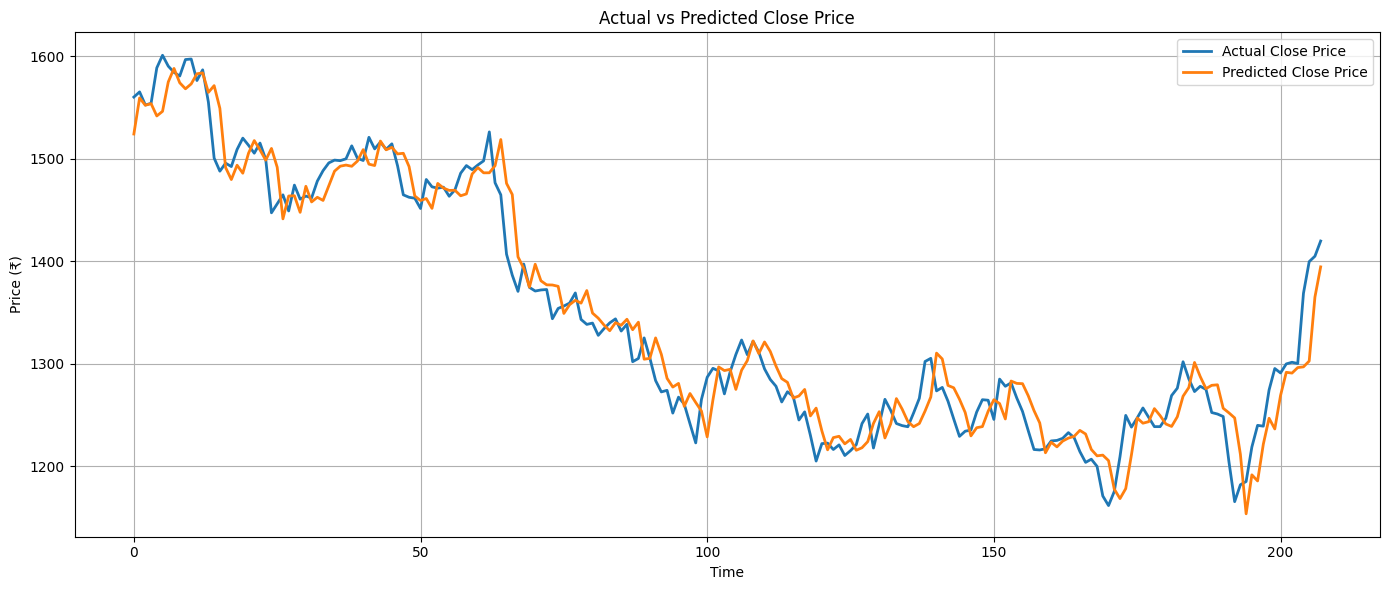

In [16]:
plt.figure(figsize=(14, 6))
plt.plot(y_true, label='Actual Close Price', linewidth=2)
plt.plot(y_pred, label='Predicted Close Price', linewidth=2)
plt.title('Actual vs Predicted Close Price')
plt.xlabel('Time')
plt.ylabel('Price (₹)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

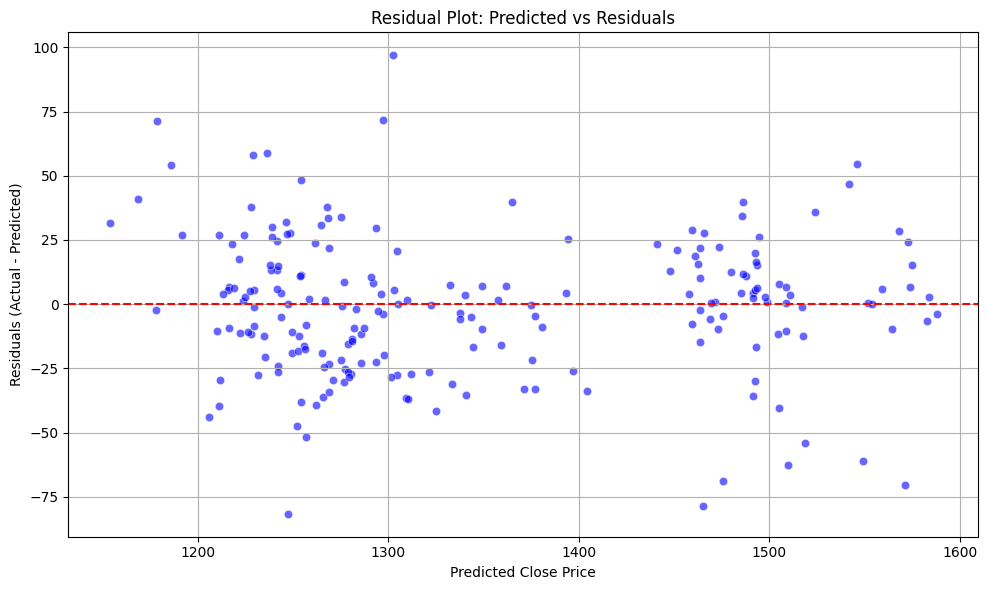

In [17]:
# Calculate residuals
residuals = y_true.flatten() - y_pred.flatten()

# Plot residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred.flatten(), y=residuals, color='blue', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot: Predicted vs Residuals')
plt.xlabel('Predicted Close Price')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
df['Date'] = pd.to_datetime(df['Date']) 
df.set_index('Date', inplace=True)  

# Get the dates corresponding to the predictions
valid_dates = df.index[-len(y_true):] 

result_df = pd.DataFrame({
    'Date': valid_dates,
    'Open': df['Open'].loc[valid_dates].values,  # Adding the Open price
    'Actual_Close': y_true.flatten(),
    'Predicted_Close': y_pred.flatten()
})

# Calculate Directional Accuracy
result_df['Actual_Direction'] = np.sign(result_df['Actual_Close'] - df['Close'].shift(1).loc[valid_dates].values)
result_df['Predicted_Direction'] = np.sign(result_df['Predicted_Close'] - df['Close'].shift(1).loc[valid_dates].values)
result_df['Correct_Direction'] = result_df['Actual_Direction'] == result_df['Predicted_Direction']




print(result_df.head())


        Date         Open  Actual_Close  Predicted_Close  Actual_Direction  \
0 2024-06-28  1531.025024   1560.150024      1523.829956               1.0   
1 2024-07-01  1562.525024   1565.175049      1561.378662              -1.0   
2 2024-07-02  1569.500000   1552.425049      1551.976074              -1.0   
3 2024-07-03  1566.324951   1554.025024      1553.907837              -1.0   
4 2024-07-04  1557.000000   1588.625000      1543.469849               1.0   

   Predicted_Direction  Correct_Direction  
0                 -1.0              False  
1                 -1.0               True  
2                 -1.0               True  
3                 -1.0               True  
4                 -1.0              False  


In [11]:
from tensorflow.keras.models import load_model
gru_model = load_model("reliancegru30.keras")

In [13]:
last_sample = X_test_seq[-1:]
prediction = gru_model.predict(last_sample)
prediction = scaler_y.inverse_transform(prediction)
print('prediction is : ',prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
prediction is :  [[1394.4141]]


In [ ]:
# Get the index of the last data point in y_test
last_index = y_test[-1]

# Find the corresponding date and features from the original dataframe 
# Assuming `main_df` has the same index as your scaled data, and contains a column 'date'
last_data_row = df.iloc[len(X_train) + len(X_test) - 1]

# Extract the date and the open price (or any other feature)
last_date = last_data_row['Date']
last_open_price = last_data_row['Open']
last_close_price = last_data_row['Close']
# Add any other feature you need, e.g., 'high', 'low', etc.

# Print the result
print(f"Last date: {last_date}")
print(f"Last Open Price: {last_open_price}")
print(f"Last Close Price: {last_close_price}")


Last date: 2025-04-30
Last Open Price: 1402.0
Last Close Price: 1405.0


In [18]:
import joblib

# Scale features and target
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(features)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(target)

# Save the scalers
joblib.dump(scaler_X, 'scaler_X_reliance.pkl')
joblib.dump(scaler_y, 'scaler_y_reliance.pkl')

['scaler_y_reliance.pkl']